### The goal is to export  the DevoLearn cell membrane segmentation model to ONNX and run inference using ONNX runtime.

Link to tutorial - https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

In [ ]:
!pip install segmentation-models-pytorch
!pip install onnx
!git clone https://github.com/DevoLearn/devolearn.git
!pip install onnxruntime

### Copy model into working directory:

In [3]:
!cp -r /content/drive/MyDrive/mydata/3d_seg_data/best_2.pth /content/

### Import Libraries:

In [5]:
import torch
import segmentation_models_pytorch as smp
import torch.onnx
import numpy as np
import onnx
import onnxruntime as ort

import cv2
import matplotlib.pyplot as plt
from PIL import Image

### Load model:
`model.eval()` sets model to inference mode -
* Normalization layers use running stats.
* deactivate dropout layers

In [ ]:
model = torch.load('/content/best_2.pth', map_location='cpu')
model.eval()

### Define sample input `x` :
* The values in this can be random as long as it is the right type and size.
* In this case, `x` is a tensor, that corresponds to a batch of one single channel, 256x256 image.
* Make sure `out` is valid.

In [ ]:
x = torch.randn(1, 1, 256, 256, requires_grad=False)
out=model(x)

### Export model:


In [ ]:
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "membrane_segmentor.onnx", # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

### Define `expand_dims_twice`:


In [9]:
def expand_dims_twice(arr):
    norm=(arr-np.min(arr))/(np.max(arr)-np.min(arr)) #normalize
    ret = np.expand_dims(np.expand_dims(norm, axis=0), axis=0)
    return(ret)

### Run inference from ONNX file:
The output image below the following cell is inferred from the ONNX model.

dims before expand_dims_twice -  (256, 256)
dims after expand_dims_twice -  (1, 1, 256, 256)


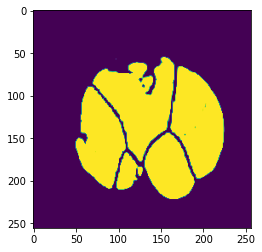

In [12]:
ort_session = ort.InferenceSession('membrane_segmentor.onnx')

img = cv2.imread("/content/devolearn/devolearn/tests/sample_data/images/seg_sample.jpg",0)
resized = cv2.resize(img, (256,256),
               interpolation = cv2.INTER_NEAREST)

print("dims before expand_dims_twice - ", resized.shape)
img_unsqueeze = expand_dims_twice(resized)
print("dims after expand_dims_twice - ", img_unsqueeze.shape)

onnx_outputs = ort_session.run(None, {'input': img_unsqueeze.astype('float32')})
plt.imshow(onnx_outputs[0][0][0])
plt.show()